In [3]:
import torch
import math
import matplotlib.pyplot as plt
import random

# 1) Value Class:

In [5]:
class Value:

    def __init__(self, data, _children = (), _op = '', label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        if self.label:
            return f"Value(label: {self.label} | data = {self.data})"
        else:
            return f"Value(data = {self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), _op = "+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return (-self) + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), _op = "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data ** other, (self,), _op = f"**{other}")

        def _backward():
            self.grad += (self.data ** (other - 1)) * other * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * (other ** -1)
    
    def __rtruediv__(self, other):
        return other * (self ** -1)

    def tanh(self):
        n = self.data
        t = (math.exp(2 * n) - 1) / (math.exp(2 * n) + 1)
        out = Value(t, (self,), _op = "tanh")

        def _backward():
            self.grad += (1 - t ** 2) * out.grad
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), _op = "exp")

        def _backward():
            self.grad += math.exp(x) * out.grad
        out._backward = _backward

        return out


    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    def print_full(self):
        print(f"{self.label} data: {self.data} grad: {self.grad}")


## Graphviz Function:

In [8]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

## Example of a Neuron

In [9]:
x1 = Value(2.0, label = "x1")
x2 = Value(0.0, label = "x2")

w1 = Value(-3.0, label = "w1")
w2 = Value(1.0, label = "w2")

b = Value(6.881373, label = "b")

x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1x2w2"
n = x1w1x2w2 + b; n.label = "n"
o = n.tanh(); o.label = "o"

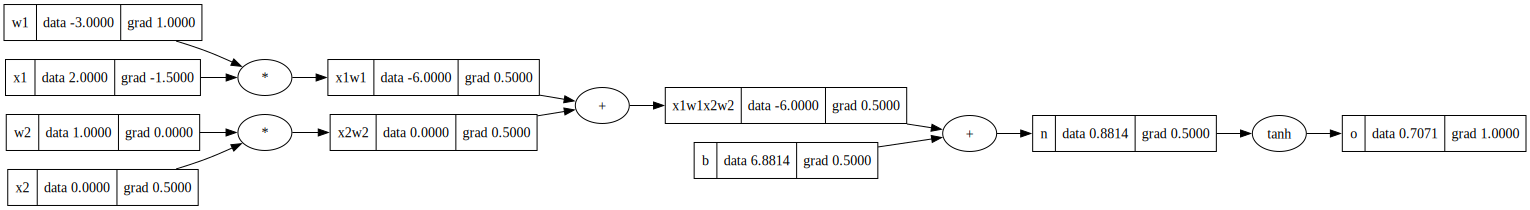

In [10]:
o.backward()
draw_dot(o)

### Automatic Test

In [11]:
o.grad = 1.0
o._backward()
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

## Bug When Using the Same Node Twice

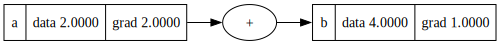

In [12]:
a = Value(2.0, label = "a")
b = a + a; b.label = "b"
b.backward()
draw_dot(b)

# solved by accumulating gradients (+= instead of =)

# 2) MLP

In [13]:
class Neuron:
    def __init__(self, nin, Nnumber, LNumber):
        self.w = [Value(random.uniform(-1,1), label = f"w{i + 1}{Nnumber}({LNumber})") for i in range(nin)]
        self.b = Value(random.uniform(-1,1), label = f"b{Nnumber}")

    def __call__(self, x):
        # w * x + b
        act = sum(wi*xi for wi, xi in zip(self.w, x)) + self.b
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout, LNumber):
        self.neurons = [Neuron(nin, i + 1, LNumber) for i in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        if len(outs) == 1:
            return outs[0] 
        return outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nins, nouts):
        sz = [nins] + nouts
        self.layers = [Layer(sz[i], sz[i + 1], i + 1) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return[p for layer in self.layers for p in layer.parameters()]

## Test 1 [3,2,1]

In [15]:
x = [Value(2.0, label = "x1"), Value(3.0, label = "x2"),Value(4, label = "x3")]
n = MLP(2, [3,2,1])
n(x)
print(len(n.parameters()))
n.parameters()

20


[Value(label: w11(1) | data = 0.6923344140438596),
 Value(label: w21(1) | data = 0.35423011916003166),
 Value(label: b1 | data = 0.4406605754475601),
 Value(label: w12(1) | data = 0.4811198166750985),
 Value(label: w22(1) | data = -0.24436107760154102),
 Value(label: b2 | data = 0.12571786510786764),
 Value(label: w13(1) | data = -0.1836389401685512),
 Value(label: w23(1) | data = 0.7525845708742935),
 Value(label: b3 | data = -0.47976566298662604),
 Value(label: w11(2) | data = 0.46665969022931275),
 Value(label: w21(2) | data = -0.5368987700975407),
 Value(label: w31(2) | data = 0.2537948592105701),
 Value(label: b1 | data = -0.9579545586330045),
 Value(label: w12(2) | data = -0.5670718136433566),
 Value(label: w22(2) | data = 0.23712738853722426),
 Value(label: w32(2) | data = 0.7390420650150049),
 Value(label: b2 | data = -0.2291421389716799),
 Value(label: w11(3) | data = -0.3546818565752574),
 Value(label: w21(3) | data = -0.7881197970869098),
 Value(label: b1 | data = -0.6827479

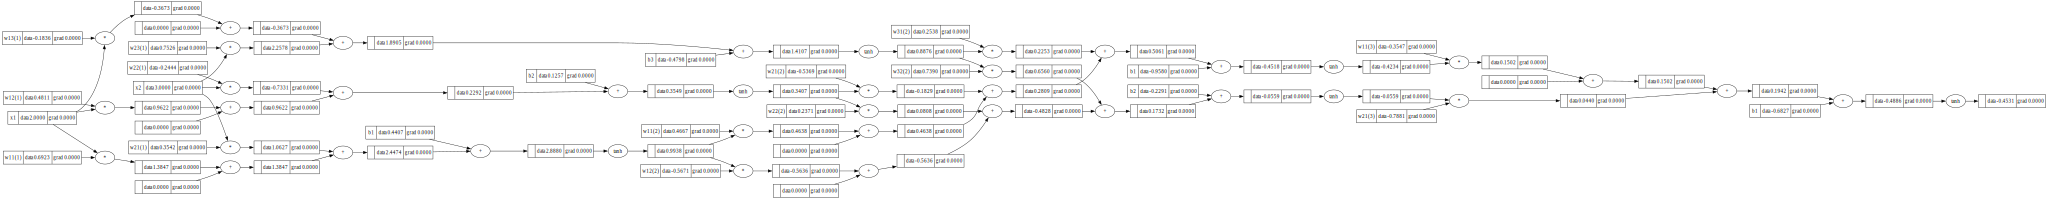

In [17]:
draw_dot(n(x))

## Example: Backpropagation

In [18]:
n = MLP(3, [4, 4, 1])
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]
y_pred = [n(x) for x in xs]
y_pred

[Value(data = 0.1975345369763548),
 Value(data = -0.6330049242121851),
 Value(data = -0.27225189175852926),
 Value(data = 0.2256066390488872)]

In [19]:
# loss function
def loss_fn(y_pred, y, errors = False):
    errors = [(yout - ygt)**2 for ygt, yout in zip(y, y_pred)]
    loss = sum(errors)
    return loss if errors else (loss, errors)

loss = loss_fn(y_pred, ys)
loss

Value(data = 1.907938591532457)

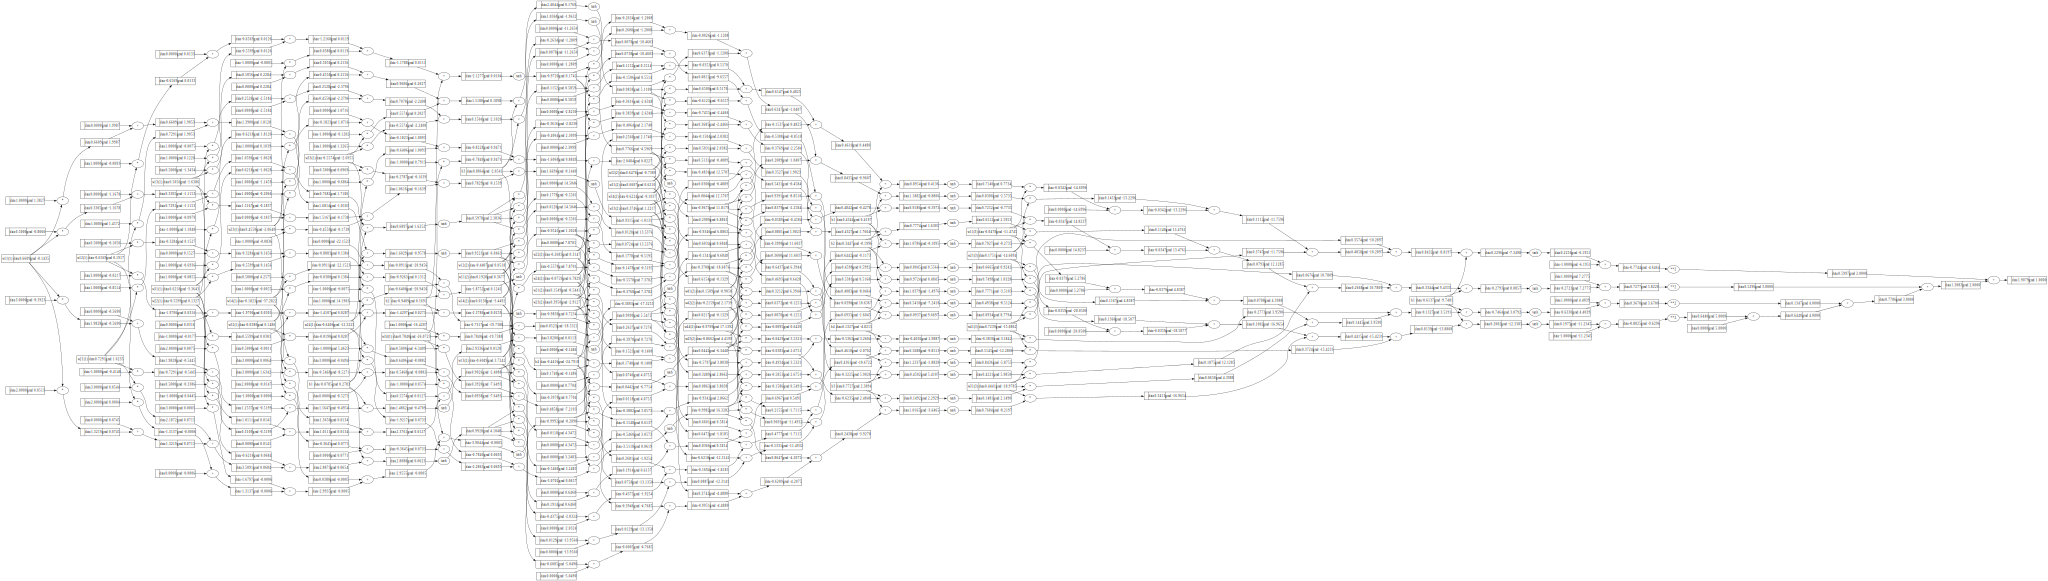

In [21]:
loss.backward()
# grad of w1 in n1 in l1
n.layers[0].neurons[0].w[0].grad
draw_dot(loss)

## Gradient Descent

In [28]:
lr = 0.05
num_epochs = 10
losses = []

for epoch in range(num_epochs):
    # zero grad (since they sum up +=)
    for p in n.parameters():
        p.grad = 0.0

    # forward pass
    y_pred = [n(x) for x in xs]

    # loss
    loss = loss_fn(y_pred, ys)
    losses.append(loss.data)

    # backward pass
    loss.backward()

    # update parameters (Optimizer.Step)
    for p in n.parameters():
        p.data -= lr * p.grad
    
    print(epoch, loss)
    

print(loss)
y_pred = [n(x) for x in xs]
y_pred

0 Value(data = 0.01546667716463658)
1 Value(data = 0.015144980761398336)
2 Value(data = 0.014836062794808477)
3 Value(data = 0.014539182540278268)
4 Value(data = 0.014253655238517541)
5 Value(data = 0.013978846918072586)
6 Value(data = 0.013714169781515767)
7 Value(data = 0.013459078085029757)
8 Value(data = 0.013213064450956435)
9 Value(data = 0.01297565656118961)
Value(data = 0.01297565656118961)


[Value(data = 0.9369094520901258),
 Value(data = -0.9583992589618219),
 Value(data = -0.9374312225278751),
 Value(data = 0.9441383550055532)]